# Minimum Distance Travelled by Ambulance in a Day

Find the optimal position to place 6 ambulances within a day (3 hour interval) in which they will travel the least amount of distance. 

Notes
- Each ambulance is committed every three hours
- Ambulances travel within allocated "sectors"

In [ ]:
# load required libraries
import pandas as pd
import numpy as np
import geopandas as gpd 
import datetime as dt
from google.colab import files

import contextily as ctx
import matplotlib.pyplot as plt
import time

# processing geojson files
from geovoronoi.plotting import subplot_for_map, plot_voronoi_polys_with_points_in_area
from geovoronoi import voronoi_regions_from_coords, points_to_coords

# clustering + visualisation
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()

from scipy.spatial import Voronoi, voronoi_plot_2d

In [ ]:
!pip install geovoronoi
!pip install geopandas

In [ ]:
!pip install contextily

In [ ]:
## then we load the data 
uploaded = files.upload()

Saving SampleSubmission.csv to SampleSubmission.csv
Saving Segment_info.csv to Segment_info.csv
Saving segments_geometry.geojson to segments_geometry.geojson
Saving submission_1.csv to submission_1.csv
Saving Train.csv to Train.csv
Saving Weather_Nairobi_Daily_GFS.csv to Weather_Nairobi_Daily_GFS.csv


In [ ]:
df = pd.read_csv('Train.csv', parse_dates=['datetime'])
print(df.shape)
df.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


## Notes: The accidents identify areas where an ambulance must reach, creating a voronoi diagram gives us the central point of these accident 
1. visualize the accident points
2. time distribution of accidents
2. cluster the accidents
3. create voronoi diagram for the points

Text(0.5, 1.0, 'Accident Locations Around Nairobi')

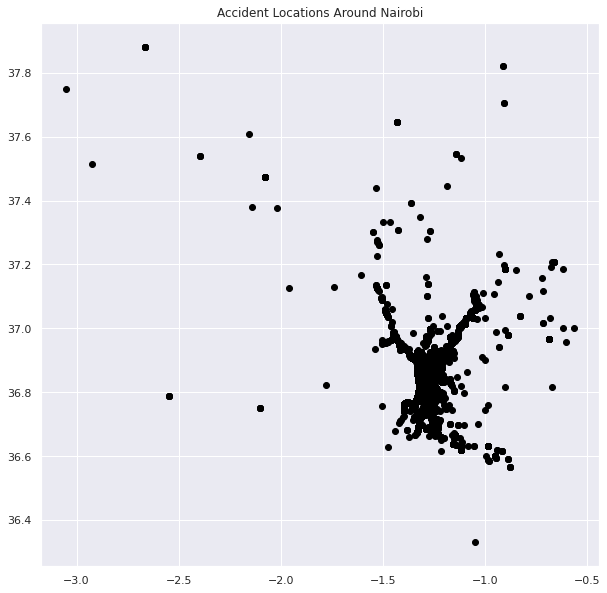

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(df['latitude'],df['longitude'],marker="o",c='black')
plt.title('Accident Locations Around Nairobi')


Text(0.5, 1.0, 'Accident Distribution per 3Hours')

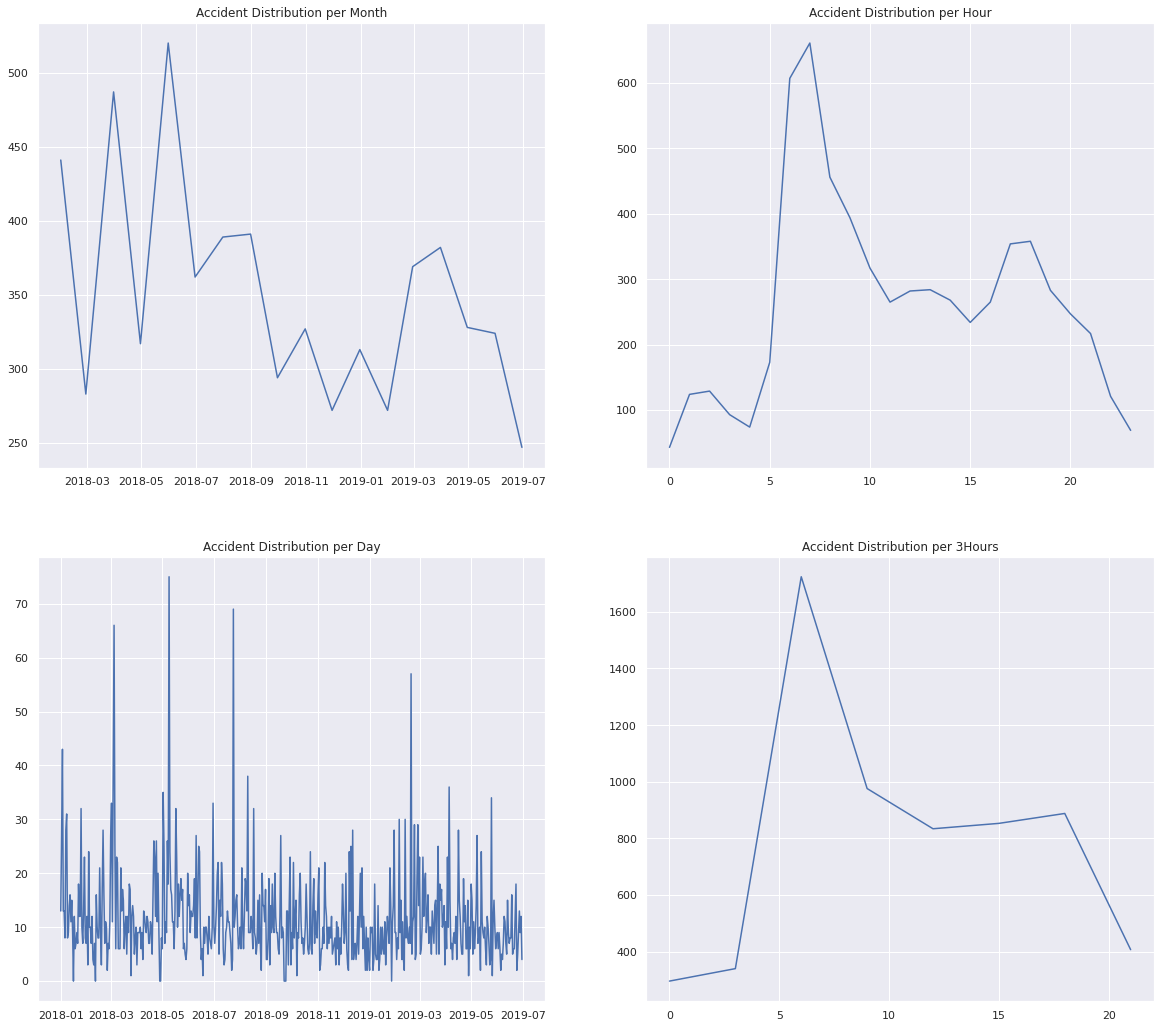

In [ ]:
# 2. timeline
 
## per month
df['idx'] = 1
df['hour'] = df['datetime'].dt.hour
 
df_month = df.resample('M', on='datetime')['idx'].count().reset_index()
df_pd_month = pd.DataFrame(df_month)
 
## per day
df_day = df.resample('D', on='datetime')['idx'].count().reset_index()
df_pd_day = pd.DataFrame(df_day)
 
## per hour
df_hour = df.groupby('hour').count().reset_index()
df_pd_hour = pd.DataFrame(df_hour)
 
## per 3 hours
df_3hours = df.resample('3H', on='datetime')['idx'].count().reset_index()
df_3hours['datetime'] = df_3hours['datetime'].dt.hour
 
df_3hours = df_3hours.groupby('datetime').sum().reset_index()
df_pd_3hours = pd.DataFrame(df_3hours)
 
#---- axes
x_day = df_pd_day['datetime']
y_day = df_pd_day['idx']
 
x_month = df_pd_month['datetime']
y_month = df_pd_month['idx']
 
x_hour = df_pd_hour['hour']
y_hour = df_pd_hour['idx']
 
x_3hours = df_pd_3hours['datetime']
y_3hours = df_pd_3hours['idx']
 
fig, axs = plt.subplots(2, 2,figsize=(20, 18))
 
axs[0, 0].plot(x_month, y_month)
axs[0, 0].set_title("Accident Distribution per Month")
 
axs[1, 0].plot(x_day, y_day)
axs[1, 0].set_title("Accident Distribution per Day")
 
axs[0, 1].plot(x_hour, y_hour)
axs[0, 1].set_title("Accident Distribution per Hour")
 
axs[1, 1].plot(x_3hours, y_3hours)
axs[1, 1].set_title("Accident Distribution per 3Hours")

On a daily basis there is very little variance on accident reports apart from time to time spike, however on a three hourly basis, the variation is evident and when modelling we need to take keen interest of this 

## NEXT STEPS 
1. CLUSTER THE ACCIDENTS WITHOUT ANY REGARD FOR TIME AND COMPARE 
2. CLUSTER THE ACCIDENTS WITH RESPECT TO THE 3 HOUR TIME DIFFERENCE THEN COMPARE THE RESULT 
3. USE THE CLUSTER CENTERS AS STARTING POINTS FOR SGD AND COMPARE WITH ABOVE RESULT

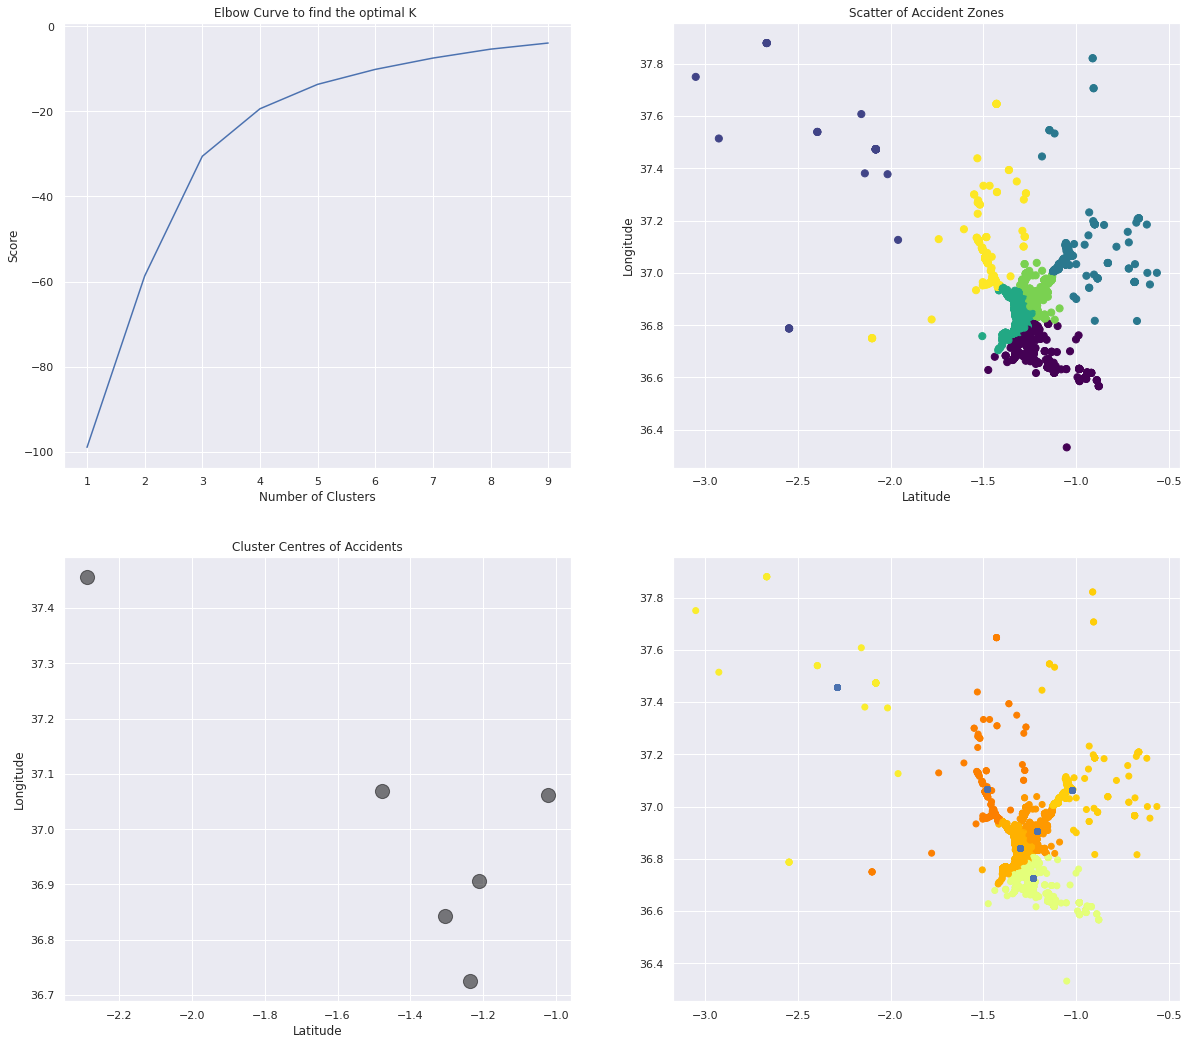

In [ ]:
# custering the accidents
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = df[['latitude']]
X_axis = df[['longitude']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Variable with the Longitude and Latitude
X=df.loc[:,['datetime','latitude','longitude']]

kmeans = KMeans(n_clusters = 6, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point

fig, axs = plt.subplots(2, 2,figsize=(20, 18))
axs[0, 0].plot(K_clusters, score)
axs[0, 0].set_title('Elbow Curve to find the optimal K ')
axs[0, 0].set_ylabel('Score')
axs[0, 0].set_xlabel('Number of Clusters')

axs[1,0].scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5,cmap='viridis')
axs[1, 0].set_title('Cluster Centres of Accidents')
axs[1, 0].set_ylabel('Longitude')
axs[1, 0].set_xlabel('Latitude')

axs[0,1].scatter(x = X['latitude'], y = X['longitude'], c=labels, s=50, cmap='viridis')
axs[0, 1].set_title('Scatter of Accident Zones')
axs[0, 1].set_ylabel('Longitude')
axs[0, 1].set_xlabel('Latitude')

## super impose the centers on the clusters 
points = pd.DataFrame([centers[:, 0], centers[:, 1]]).transpose()
points.reset_index(inplace=True)
points['cluster_label']=points.index
result=pd.merge(X,points,
               how='left')

axs[1,1].scatter(result['latitude'],result['longitude'],c=result['cluster_label'],cmap='Wistia')
axs[1,1].scatter(result[0],result[1])

In [ ]:
# define a scoring function 
def score_ambulance(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')


In [ ]:
## use this clustering to get aambulance locations 

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = centers.tolist()[ambulance][0]
    sub['A'+str(ambulance)+'_Longitude'] = centers.tolist()[ambulance][1]
sub.head()


,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-01-01 00:00:00,-1.234915,36.725122,-2.288814,37.456547,-1.021416,37.061628,-1.304174,36.842158,-1.212076,36.906644,-1.478652,37.068348
1,2019-01-01 03:00:00,-1.234915,36.725122,-2.288814,37.456547,-1.021416,37.061628,-1.304174,36.842158,-1.212076,36.906644,-1.478652,37.068348
2,2019-01-01 06:00:00,-1.234915,36.725122,-2.288814,37.456547,-1.021416,37.061628,-1.304174,36.842158,-1.212076,36.906644,-1.478652,37.068348
3,2019-01-01 09:00:00,-1.234915,36.725122,-2.288814,37.456547,-1.021416,37.061628,-1.304174,36.842158,-1.212076,36.906644,-1.478652,37.068348
4,2019-01-01 12:00:00,-1.234915,36.725122,-2.288814,37.456547,-1.021416,37.061628,-1.304174,36.842158,-1.212076,36.906644,-1.478652,37.068348


In [ ]:
score_ambulance(sub,reference)

106.31666947001685

## Now cluster with time in mind 


In [ ]:

def flaten(centers_list):
    """flatening the list of tuples [(x0,y0),(x1,y1),(x2,y2),(x3,y3)] to [x0,y0,x1,y1,x2,y2,x3,y3]"""
    merged = list(zip(centers_list[:,0],centers_list[:,1]))
    return [c for couple in merged for c in couple ]

In [ ]:
uploaded=files.upload()

In [ ]:

submission = pd.read_csv('submission_1.csv', parse_dates=['date'])

loop throught [0,3,6,9,12,15,18,21] to split the training dataset into 8 chunks based on the hours of the crushes and create separate data sets then create seperated models based on those datasets

In [ ]:
for i in range(0,22,3):
    d = df[(df['datetime'].dt.hour>=i) & (df['datetime'].dt.hour<=i+3)]
    kmeans = KMeans(n_clusters=6, random_state=0).fit(d[['latitude','longitude']])
    t = flaten(kmeans.cluster_centers_)
    submission.loc[submission['date'].dt.hour == i, ['A0_Latitude','A0_Longitude',
                                     'A1_Latitude','A1_Longitude','A2_Latitude','A2_Longitude',
                                     'A3_Latitude','A3_Longitude','A4_Latitude','A4_Longitude',
                                     'A5_Latitude','A5_Longitude']] = t

submission.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-01-01 00:00:00,-1.195523,36.924074,-2.497671,37.788891,-1.302038,36.843262,-0.912302,37.067283,-1.251698,36.725445,-1.457051,37.124484
1,2019-01-01 03:00:00,-0.996639,37.044251,-1.318464,36.846116,-2.549553,37.629724,-1.247332,36.736116,-1.520020,37.156328,-1.225661,36.887187
2,2019-01-01 06:00:00,-1.220844,36.892566,-2.272487,37.384144,-1.249482,36.731703,-1.053195,37.103977,-1.450653,37.028129,-1.305977,36.838725
3,2019-01-01 09:00:00,-1.277163,36.868885,-1.026252,36.620439,-2.282399,37.312977,-1.053138,37.028036,-1.456808,37.029627,-1.280280,36.763227
4,2019-01-01 12:00:00,-1.282393,36.823604,-1.142527,36.976261,-1.387766,36.957165,-0.816886,37.182421,-1.941905,37.501344,-1.007614,36.618763


In [ ]:
submission.shape

(2921, 13)

In [ ]:
## USE CLUSTER CENTERS AS STARTING POINTS FOR SGD 
centers

array([[-1.23491483, 36.72512159],
       [-2.28881419, 37.45654699],
       [-1.02141628, 37.06162761],
       [-1.30417353, 36.84215825],
       [-1.21207624, 36.90664441],
       [-1.47865223, 37.06834783]])

In [ ]:
import fastai
import torch

In [ ]:
amb_locs=torch.tensor(centers)
amb_locs.requires_grad_() # Tell pytorch to calculate gradients
initial_locs = amb_locs.clone() # Save originals for later
amb_locs # View our set of initial locations

tensor([[-1.2349, 36.7251],
        [-2.2888, 37.4565],
        [-1.0214, 37.0616],
        [-1.3042, 36.8422],
        [-1.2121, 36.9066],
        [-1.4787, 37.0683]], dtype=torch.float64, requires_grad=True)

In [ ]:
# Crash locations - turn the training data into a tensor we can work with
crash_locs = torch.tensor(df[['latitude', 'longitude']].values) # To Tensor

In [ ]:
# speciffy the loss function and preserve the gradient while at it 
def loss_fn(crash_locs, amb_locs):
  """For each crash we find the dist to the closest ambulance, and return the mean of these dists."""
  # Dists to first ambulance
  dists_split = crash_locs-amb_locs[0]
  dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
  min_dists = dists
  for i in range(1, 6):
    # Update dists so they represent the dist to the closest ambulance
    dists_split = crash_locs-amb_locs[i]
    dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
    min_dists = torch.min(min_dists, dists)
  
  return min_dists.mean()

In [ ]:
# Calculate loss:
loss = loss_fn(crash_locs, amb_locs)
loss

tensor(0.0580, dtype=torch.float64, grad_fn=<MeanBackward0>)

These gradients tell us which way to move the locations to reduce the loss. This is all we need to do some gradient descent! We'll pick a learning rate, and then run through 1000 steps, updating the locations each time:

In [ ]:
amb_locs.grad = None # Reset gradients
lr=0.0055567 # Pick LR
for i in range(1000):
  loss = loss_fn(crash_locs, amb_locs) # Find loss
  if i % 100 == 0: print('Loss:', loss.item()) # Print loss
  loss.backward() # Calc grads
  amb_locs.data -= lr * amb_locs.grad.data # Update locs
  amb_locs.grad = None # Reset gradients for next step

Loss: 0.05797689184329011
Loss: 0.05595555205423887
Loss: 0.05550703059521236
Loss: 0.05536048465464951
Loss: 0.05525015861485471
Loss: 0.055163241711835065
Loss: 0.05510392293513274
Loss: 0.05505235672528715
Loss: 0.05501379563959697
Loss: 0.054985476499606716


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


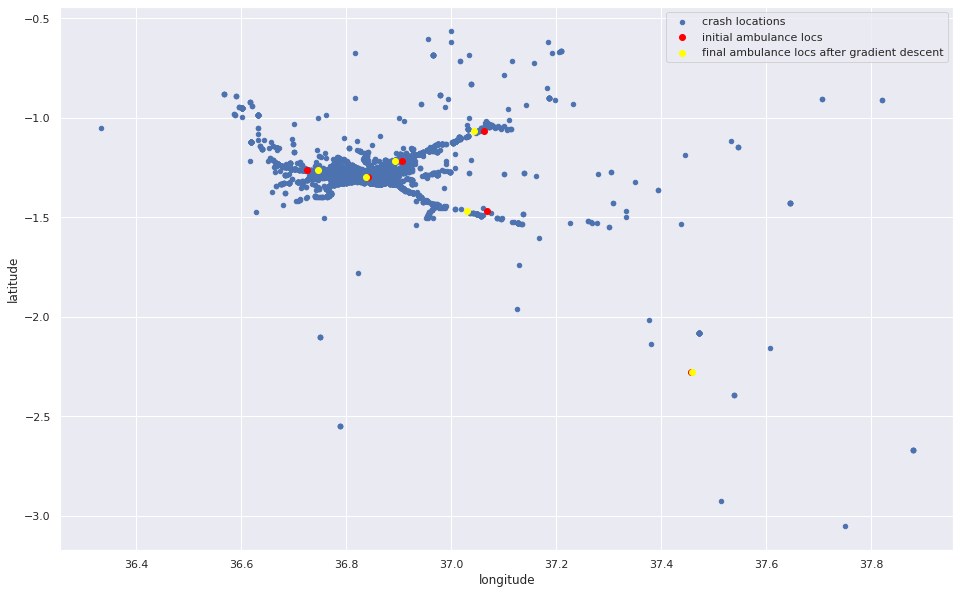

In [ ]:
# Plot crashes and ambulance locations
ax = df.plot(y='latitude', x='longitude', kind='scatter', figsize=(16, 10), label='crash locations')
ax.scatter(initial_locs[:,1].detach().numpy(), amb_locs[:,0].detach().numpy(), c='red', label='initial ambulance locs')
ax.scatter(amb_locs[:,1].detach().numpy(), amb_locs[:,0].detach().numpy(), c='yellow', label='final ambulance locs after gradient descent')
ax.legend()

In [ ]:
## SGD 
# Split for validation
train_locs = crash_locs[:-1000]
val_locs = crash_locs[-1000:]

# Load crash locs from train into a dataloader
dl = torch.utils.data.DataLoader(train_locs, batch_size=100, shuffle=True)

# Set up ambulance locations
amb_locs=torch.tensor(centers)
amb_locs.requires_grad_()

# Set vars
lr=2e-3
n_epochs = 300

# Store loss over time
train_losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
   # Run through batches
  for crashes in dl:
    loss = loss_fn(crashes, amb_locs) # Find loss for this batch of crashes
    loss.backward() # Calc grads
    amb_locs.data -= lr * amb_locs.grad.data # Update locs
    amb_locs.grad = None # Reset gradients for next step
    train_losses.append(loss.item())
    val_losses.append(loss_fn(val_locs, amb_locs).item()) # Can remove as this lows things down

  # Print validation loss
  print('Val loss:', loss_fn(val_locs, amb_locs).item())

Val loss: 0.05805569959991891
Val loss: 0.057510957121637146
Val loss: 0.05710471961901071
Val loss: 0.05684356178617754
Val loss: 0.05663331578378279
Val loss: 0.056489877635178425
Val loss: 0.056348419289949284
Val loss: 0.05618509497753811
Val loss: 0.0560484286433254
Val loss: 0.055930159351594025
Val loss: 0.05577833482894576
Val loss: 0.05564313799997595
Val loss: 0.055521126633911365
Val loss: 0.05545638185052766
Val loss: 0.055422141586905525
Val loss: 0.055368904713181066
Val loss: 0.05533595285768092
Val loss: 0.05530211698511249
Val loss: 0.055247546881916534
Val loss: 0.05521685013932728
Val loss: 0.05519735874044024
Val loss: 0.05518427719417232
Val loss: 0.05513722330425737
Val loss: 0.05509194795481106
Val loss: 0.055031440129421315
Val loss: 0.055016847451586116
Val loss: 0.05498783480841368
Val loss: 0.05495844851814209
Val loss: 0.054930969335763774
Val loss: 0.054938723362406024
Val loss: 0.054887781251532375
Val loss: 0.05484949296353102
Val loss: 0.0548736601029214

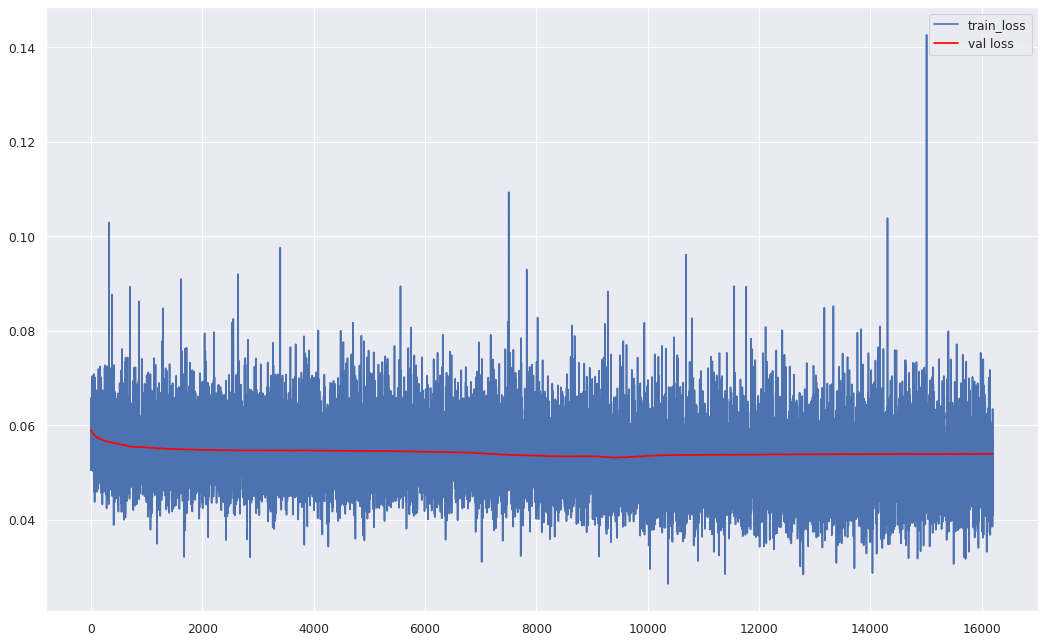

In [ ]:
plt.figure(num=None, figsize=(16, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, c='red', label='val loss')
plt.legend()

In [ ]:
sgd_centres=pd.DataFrame(amb_locs.detach().numpy(),columns=['lat','long'])
# Create submission dataframe
submission_sgd = pd.DataFrame({
    'date':dates
})

for ambulance in range(6):
    submission_sgd['A'+str(ambulance)+'_Latitude'] = sgd_centres.iloc[ambulance][0]
    submission_sgd['A'+str(ambulance)+'_Longitude'] = sgd_centres.iloc[ambulance][1]
submission_sgd.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-01-01 00:00:00,-1.262909,36.740672,-2.199612,37.46312,-1.067892,37.044733,-1.285691,36.823099,-1.218881,36.89198,-1.331483,36.888167
1,2019-01-01 03:00:00,-1.262909,36.740672,-2.199612,37.46312,-1.067892,37.044733,-1.285691,36.823099,-1.218881,36.89198,-1.331483,36.888167
2,2019-01-01 06:00:00,-1.262909,36.740672,-2.199612,37.46312,-1.067892,37.044733,-1.285691,36.823099,-1.218881,36.89198,-1.331483,36.888167
3,2019-01-01 09:00:00,-1.262909,36.740672,-2.199612,37.46312,-1.067892,37.044733,-1.285691,36.823099,-1.218881,36.89198,-1.331483,36.888167
4,2019-01-01 12:00:00,-1.262909,36.740672,-2.199612,37.46312,-1.067892,37.044733,-1.285691,36.823099,-1.218881,36.89198,-1.331483,36.888167


In [ ]:
score_ambulance(submission_sgd, reference)

95.28567012788986

In [ ]:

submission_sgd.to_csv('submission_41.csv',index=False)

In [ ]:

submission.to_csv('submission_42.csv',index=False)